In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sc
np.set_printoptions(suppress=True)

In [35]:
def read_file(filename):
    names, errors, shape, loss = [], [], [], []
    with open(filename, 'r') as file:
        for line in file:
            # Split the line into its components using whitespace as the delimiter
            parts = line.strip().split()
            # Extract the "name", "val1", and "val2" from the parts list
            names.append(parts[0])
            errors.append(float(parts[1]))
            shape.append(float(parts[2]))
            if len(parts) == 4:
                loss.append(float(parts[3]))
    return names, errors, shape, loss

def checkNumVar(codeNum, varNum):
    # varNum: 1-6, codeNum: 0-63
    for i in range(varNum):
        out = int(codeNum%2)
        codeNum = int(codeNum/2)
    return out


def getCodeNumsWithVars(vars, numTotVars=7):
    codeNums = []
    for i in range(2**numTotVars):
        lst = []
        for v in vars:
            lst.append(checkNumVar(i, v))
        if (all(num == 1 for num in lst)):
            codeNums.append(i)
    return codeNums


def getCodeNumsNumVars(numVars, numTotVars=7):
    codeNums = []
    for i in range(2**numTotVars):
        lst = []
        for v in range(1, numTotVars+1):
            lst.append(checkNumVar(i, v))
        if (sum(lst) == numVars):
            codeNums.append(i)
    return codeNums

def getVarsFromCode(code):
    vars = []
    count = 0
    while code > 0:
        count += 1
        if(code%2):
            vars.append(count)
        code = int(code/2)
    return vars

def colorScale(hexColor1, hexColor2, numColors=2):
    out = []
    hexColor1, hexColor2 = hexColor1.lstrip('#'), hexColor2.lstrip('#')
    r1, g1, b1 = int(hexColor1[0:2], 16), int(hexColor1[2:4], 16), int(hexColor1[4:6], 16)
    r2, g2, b2 = int(hexColor2[0:2], 16), int(hexColor2[2:4], 16), int(hexColor2[4:6], 16)
    slope_r, slope_g, slope_b = (r2-r1)/(numColors-1), (g2-g1)/(numColors-1), (b2-b1)/(numColors-1)
    for i in range(numColors):
        out.append("#" + "{:02x}".format(int(r1+i*slope_r)).upper() + "{:02x}".format(int(g1+i*slope_g)).upper() + "{:02x}".format(int(b1+i*slope_b)).upper())
    return out

def getInterval(errVal, spacing=0.2):
    for v in np.arange(3.5, 5.001, spacing):
        if v >= errVal and v - spacing < errVal:
            return (round(v-spacing, 3), round(v, 3))
        
def getCodeFromBinary(s):
    for i in range(len(s)):
        if s[i].isalpha():
            return getCodeFromBinary(s[:i] + '0' + s[i+1:]) + getCodeFromBinary(s[:i] + '1' + s[i+1:])
    return [int(s, 2)]

def checkBadCombinations(names, losses, nvars = [2], lossThresh = 32):
    badNames = []
    for n, l in zip(names, losses):
        if len(n.split("_")) - 3 in nvars and l > lossThresh:
            badNames.append("_".join(n.split("_")[3:]))
    return sorted(list(set(badNames)))

In [36]:
print(colorScale("#00ffff", "#000000", 4))

['#00FFFF', '#00AAAA', '#005555', '#000000']


In [114]:
def plotEval(namesDifferentVars, errorsDifferentVars, shapesDifferentVars, lossesDifferentVars, var=[], intervalLoss=(0,0), intervalError=(0,0), fullNames=[]):
    colorsVars = {0: "#FFFF00", 1: "#AAAA00", 2: "#FF0000", 3: "#AA0000", 4: "#00FF00", 5: "#00AA00", 6: "#0000FF", 7: "#0000AA", 8: "#00FFFF", 9: "#00AAAA"}
    plt.figure(figsize=(12, 8))

    for n, e, s, l in zip(namesDifferentVars[0], errorsDifferentVars[0], shapesDifferentVars[0], lossesDifferentVars[0]):
        if n == "RECO":
            plt.scatter(e, l, color="#33bb88", label='Reco', s=100, alpha=1.0, edgecolor="#000000")
    plt.scatter(errorsDifferentVars[0][:-1], lossesDifferentVars[0][:-1], color="#FFFF00", label='0 vars', s=30, alpha=1.0, edgecolor="#000000")

    for n, e, s, l in zip(namesDifferentVars[1:], errorsDifferentVars[1:], shapesDifferentVars[1:], lossesDifferentVars[1:]):
        if len(n) > 0:
            numVars = len(n[0].split("_")) - 3
            if numVars > 0:
                plt.scatter(e, l, color=colorsVars[numVars], s=30, label="{} vars".format(numVars), alpha=1.0, edgecolor="#222222")

    avgErr, avgLoss, count = 0, 0, 0
    for n, e, s, l in zip(namesDifferentVars, errorsDifferentVars, shapesDifferentVars, lossesDifferentVars):
        for i in range(len(n)):
            if any(item in n[i].split("_")[1:] for item in var):
                if e[i] < 5 and l[i] < 29:
                    print(n[i], e[i], l[i])
                    plt.scatter(e[i], l[i], color="#cccc00", s=80, alpha=1.0, edgecolor="#000000")
                avgErr += e[i]
                avgLoss += l[i]
                count += 1
            if (l[i] > intervalLoss[0] and l[i] < intervalLoss[1] and e[i] > intervalError[0] and e[i] < intervalError[1]) or n[i] in fullNames:
                print(n[i], "df", getVarsFromCode(int(n[i].split("_")[1].replace("df", ""))), "\tdl", getVarsFromCode(int(n[i].split("_")[2].replace("dl", ""))), e[i], l[i])
                #plt.annotate(n[i], (e[i], l[i]), textcoords="offset points", xytext=(5,-2), ha='left')
                plt.scatter(e[i], l[i], color="#aaaaff", s=70, alpha=1.0, edgecolor="#000000")


    


    '''

    mine_l, mine_e, mine_s = 0, 10, 0
    minl_l, minl_e, minl_s = 0, 0, 200

    for label, e, s in zip(names_filt, errors_filt, loss_filt):
        if s < 24 and e < 4.5:
            if e < mine_e:
                mine_l, mine_e, mine_s = label, e, s
            if s < minl_s:
                minl_l, minl_e, minl_s = label, e, s
    print(mine_l, mine_e, mine_s)
    plt.annotate(mine_l, (mine_e, mine_s), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
    plt.scatter(mine_e, mine_s, color="#ffffff", s=60, alpha=1.0, edgecolor="#000000")
    print(minl_l, minl_e, minl_s)
    plt.annotate(minl_l, (minl_e, minl_s), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
    plt.scatter(minl_e, minl_s, color="#ffffff", s=60, alpha=1.0, edgecolor="#000000")

    mine_l, mine_e, mine_s = 0, 10, 0
    minl_l, minl_e, minl_s = 0, 0, 200

    for label, e, s in zip(names_filt, errors_filt, loss_filt):
        if s < 22 and e < 4.67:
            if e < mine_e:
                mine_l, mine_e, mine_s = label, e, s
            if s < minl_s:
                minl_l, minl_e, minl_s = label, e, s
    print(mine_l, mine_e, mine_s)
    plt.annotate(mine_l, (mine_e, mine_s), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
    plt.scatter(mine_e, mine_s, color="#ffffff", s=60, alpha=1.0, edgecolor="#000000")
    print(minl_l, minl_e, minl_s)
    plt.annotate(minl_l, (minl_e, minl_s), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
    plt.scatter(minl_e, minl_s, color="#ffffff", s=60, alpha=1.0, edgecolor="#000000
    '''
    '''
    namesTotal, errorsTotal, lossesTotal = [], [], []

    for n, e, l in zip(namesDifferentVars, errorsDifferentVars, lossesDifferentVars):
        namesTotal += n
        errorsTotal += e
        lossesTotal += l

    classified = {}
    for n, e, l in zip(namesTotal, errorsTotal, lossesTotal):
        if e > 3.5 and e < 5:
            inter = getInterval(e, spacing=0.02)
            if inter not in classified:
                classified[inter] = [[n, float(e), float(l)]]
            else:
                classified[inter] = classified[inter] + [[n, float(e), float(l)]]

    for key, value in classified.items():
        models = np.array(classified[key])
        losses = np.asarray(models[:, 2], dtype=float)

        midpoint50 = (np.max(losses) + np.min(losses)) / 2
        midpoint25 = np.min(losses) + (np.max(losses) - np.min(losses))*0.25
        midpoint75 = np.min(losses) + (np.max(losses) - np.min(losses))*0.75
        midpoint20 = np.min(losses) + (np.max(losses) - np.min(losses))*0.20
        midpoint40 = np.min(losses) + (np.max(losses) - np.min(losses))*0.40
        midpoint60 = np.min(losses) + (np.max(losses) - np.min(losses))*0.60
        midpoint80 = np.min(losses) + (np.max(losses) - np.min(losses))*0.80


        newKeyVals = np.asarray([models[np.where(losses == np.percentile(losses, 0, method="nearest"))[0][0]],
                                models[np.abs(losses - midpoint20).argmin()],
                                models[np.abs(losses - midpoint40).argmin()],
                                models[np.abs(losses - midpoint60).argmin()],
                                models[np.abs(losses - midpoint80).argmin()],
                                models[np.where(losses == np.percentile(losses, 100, method="nearest"))[0][0]]])
        newKeyVals = np.asarray([models[np.where(losses == np.percentile(losses, 0, method="nearest"))[0][0]]])
        
        classified[key] = newKeyVals

    newModels = []

    for key, value in classified.items():
        for e in value:
            plt.scatter(float(e[1]), float(e[2]), color="#000000", s=160, alpha=1.0, edgecolor="#000000")
            newModels.append(e[0])
    print(len(newModels))'''
    
    '''
    newModels = []
    for n, e, s in zip(names_filt, errors_filt, loss_filt):
        if s < estimation(e, *p):
            newModels.append(n)
    '''
    

    x = np.linspace(2.75, 6.0)
    plt.plot(x, estimation(x, *p), color="#2244ff", linewidth=2)

    plt.xlabel('Mean error in pt (predicted - gen) GeV')
    plt.ylabel('Loss')
    plt.title('Mean PT error pt vs Loss')
    xmin, xmax, xsep = 2.0, 6, 0.5
    #xmin, xmax, xsep = 6.2, 6.35, 0.01
    ymin, ymax, ysep = 5, 60, 5
    #ymin, ymax, ysep = 172, 180, 1
    #plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin, ymax+0.001, ysep))
    #plt.xticks(np.arange(xmin, xmax+0.001, xsep))
    plt.grid()
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    return newModels

    #print(var, avgErr/count, avgLoss/count, count)

In [115]:
#subprocess.run("bash joinRMSfiles.sh", shell=True, capture_output=True, text=True)
forbidden = ["v25", "v26", "v27"]
forbidden += []
forbidden = []

arrs = read_file("eval_all_phi.out")
names_filt = [el for el, name in zip(arrs[0], arrs[0]) if not any(n in name.split("_") for n in forbidden)]
errors_filt = [el for el, name in zip(arrs[1], arrs[0]) if not any(n in name.split("_") for n in forbidden)]
shapes_filt = [el for el, name in zip(arrs[2], arrs[0]) if not any(n in name.split("_") for n in forbidden)]
loss_filt = [el for el, name in zip(arrs[3], arrs[0]) if not any(n in name.split("_") for n in forbidden)]

print(len(names_filt), len(errors_filt), len(shapes_filt), len(loss_filt))

namesDifferentVars, errorsDifferentVars, shapesDifferentVars, lossesDifferentVars = [[] for x in range(10)], [[] for x in range(10)], [[] for x in range(10)], [[] for x in range(10)]
for n, e, s, l in zip(names_filt, errors_filt, shapes_filt, loss_filt):
    numVars = len(n.split("_")) - 3
    if numVars >= 0:
        namesDifferentVars[numVars].append(n)
        errorsDifferentVars[numVars].append(e)
        shapesDifferentVars[numVars].append(s)
        lossesDifferentVars[numVars].append(l)
    if n == "RECO":
        namesDifferentVars[0].append(n)
        errorsDifferentVars[0].append(e)
        shapesDifferentVars[0].append(s)
        lossesDifferentVars[0].append(l)
expected = [34, 480, 1456, 3008, 2048, 2016, 1344, 576, 144, 16]
for i, l in enumerate(namesDifferentVars):
    print("NumVars: {}, len: {} / {}".format(i, len(l), expected[i]))



def estimation(x, a, b, c):
    return a + b*np.exp(-c*x)

p,q = sc.curve_fit(estimation, errors_filt, loss_filt, p0=[1, 200, 0.7])
print(p)
print(np.sqrt(np.diag(q)))

11154 11154 11154 11154
NumVars: 0, len: 34 / 34
NumVars: 1, len: 480 / 480
NumVars: 2, len: 1456 / 1456
NumVars: 3, len: 3012 / 3008
NumVars: 4, len: 2064 / 2048
NumVars: 5, len: 2026 / 2016
NumVars: 6, len: 1346 / 1344
NumVars: 7, len: 576 / 576
NumVars: 8, len: 144 / 144
NumVars: 9, len: 16 / 16
[  0.21340494 373.62622177   0.70145433]
[ 0.39246572 15.80964812  0.01564631]


In [116]:
dlCodesPhiPhoton = ["dl" + str(x) for x in getCodeFromBinary("111xx110x100")]
print(dlCodesPhiPhoton)

dlCodesNoPhiPhoton = ["dl" + str(x) for x in getCodeFromBinary("111xx110x000")]
print(dlCodesNoPhiPhoton)

['dl3684', 'dl3692', 'dl3812', 'dl3820', 'dl3940', 'dl3948', 'dl4068', 'dl4076']
['dl3680', 'dl3688', 'dl3808', 'dl3816', 'dl3936', 'dl3944', 'dl4064', 'dl4072']


BDTG_df15_dl3684_v0_v1 df [1, 2, 3, 4] 	dl [3, 6, 7, 10, 11, 12] 3.9362027839044305 20.81964885755457
BDTG_df15_dl3684_v1_v4 df [1, 2, 3, 4] 	dl [3, 6, 7, 10, 11, 12] 4.026550747794392 19.031699573287558
BDTG_df15_dl3684_v0_v1_v4 df [1, 2, 3, 4] 	dl [3, 6, 7, 10, 11, 12] 3.9539162858751733 20.782679046789134
BDTG_df15_dl3684_v0_v1_v9 df [1, 2, 3, 4] 	dl [3, 6, 7, 10, 11, 12] 3.9426019480332712 20.72431080496021
BDTG_df15_dl3684_v1_v4_v9 df [1, 2, 3, 4] 	dl [3, 6, 7, 10, 11, 12] 4.034347413068679 19.033139847489473
BDTG_df15_dl3684_v0_v1_v4_v9 df [1, 2, 3, 4] 	dl [3, 6, 7, 10, 11, 12] 3.9550250568957055 20.69299249567951


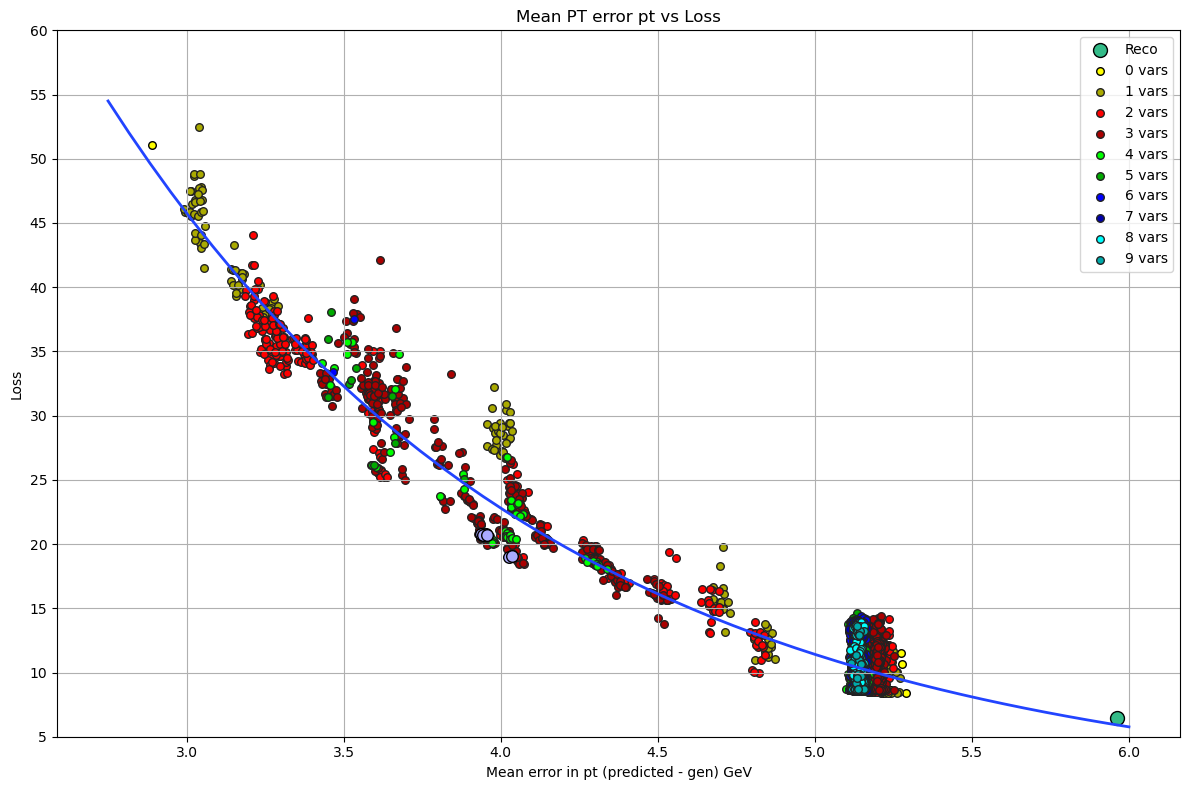

In [117]:
#Threshold of a valid model: loss < 20
newModels = plotEval(namesDifferentVars, errorsDifferentVars, shapesDifferentVars, lossesDifferentVars, var=[], intervalLoss=(21, 21), intervalError=(4.5, 4.5), fullNames=["BDTG_df15_dl3684_v0_v1",
"BDTG_df15_dl3684_v0_v1_v4",
"BDTG_df15_dl3684_v0_v1_v9",
"BDTG_df15_dl3684_v0_v1_v4_v9",
"BDTG_df15_dl3684_v1_v4",
"BDTG_df15_dl3684_v1_v4_v9"])

In [13]:
bad = checkBadCombinations(names_filt, loss_filt, nvars=[2], lossThresh=27)
print(len(bad), bad)
bad = checkBadCombinations(names_filt, loss_filt, nvars=[3], lossThresh=27)
print(len(bad), bad)
bad = checkBadCombinations(names_filt, loss_filt, nvars=[2,3], lossThresh=27)
print(len(bad), bad)

10 ['v0_v12', 'v0_v14', 'v0_v3', 'v0_v7', 'v0_v8', 'v3_v4', 'v4_v12', 'v4_v14', 'v4_v7', 'v4_v8']
9 ['v0_v1_v10', 'v0_v1_v11', 'v0_v4_v11', 'v1_v4_v10', 'v1_v4_v11', 'v1_v4_v12', 'v4_v10_v12', 'v4_v11_v12', 'v4_v9_v12']
19 ['v0_v12', 'v0_v14', 'v0_v1_v10', 'v0_v1_v11', 'v0_v3', 'v0_v4_v11', 'v0_v7', 'v0_v8', 'v1_v4_v10', 'v1_v4_v11', 'v1_v4_v12', 'v3_v4', 'v4_v10_v12', 'v4_v11_v12', 'v4_v12', 'v4_v14', 'v4_v7', 'v4_v8', 'v4_v9_v12']


109
BDTG_df15_dl3684
RECO                     	5.963 (+0.0\%)	6.438	4.516 (+0.0\%)
BDTG_df15_dl3684_v0_v1   	3.936 (-34.0\%)	20.82	3.312 (-26.6\%)
BDTG_df15_dl3684_v0_v1_v4	3.954 (-33.7\%)	20.783	3.328 (-26.3\%)
BDTG_df15_dl3684_v0_v1_v4_v9	3.955 (-33.7\%)	20.693	3.328 (-26.3\%)
BDTG_df15_dl3684_v0_v1_v9	3.943 (-33.9\%)	20.724	3.312 (-26.6\%)
BDTG_df15_dl3684_v1_v4   	4.027 (-32.5\%)	19.032	3.359 (-25.6\%)
BDTG_df15_dl3684_v1_v4_v9	4.034 (-32.3\%)	19.033	3.344 (-26.0\%)
109


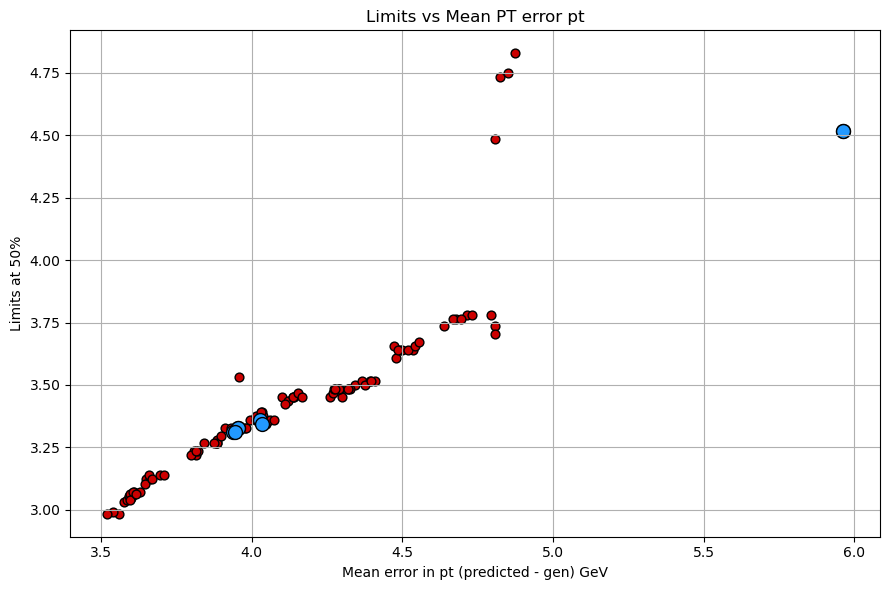

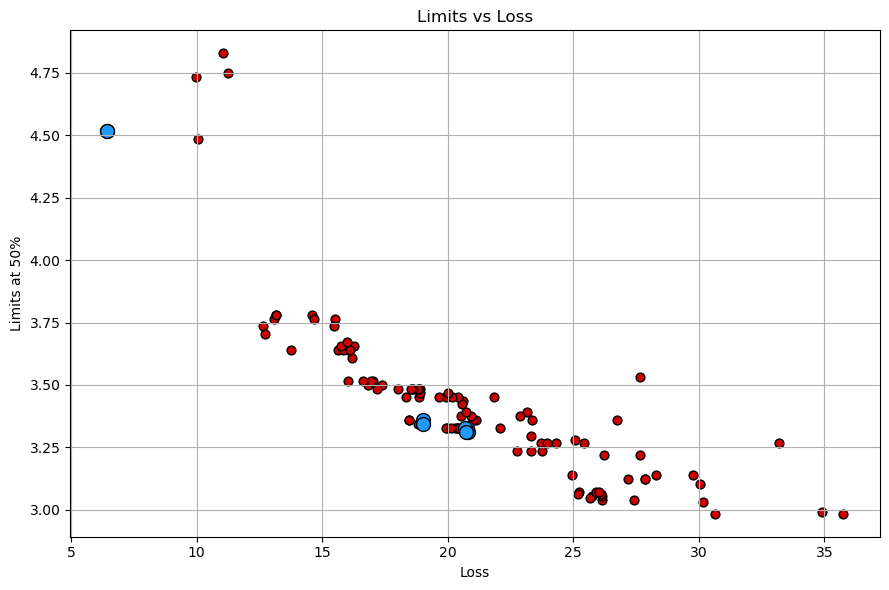

In [110]:
filename = "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/FITS_marti/phi_limits.out"
names, errors, loss, limits = [], [], [], []
with open(filename, 'r') as file:
    for line in file:
        # Split the line into its components using whitespace as the delimiter
        parts = line.strip().split()
        for i, zipped in enumerate(zip(names_filt, errors_filt, loss_filt)):
            if zipped[0] == parts[0]:
                names.append(parts[0])
                errors.append(float(zipped[1]))
                loss.append(float(zipped[2]))
                limits.append(float(parts[1]))

print(len(names))

annotations = []
namesAnn=["BDTG_df15_dl3684_v0_v1",
"BDTG_df15_dl3684_v0_v1_v4",
"BDTG_df15_dl3684_v0_v1_v9",
"BDTG_df15_dl3684_v0_v1_v4_v9",
"BDTG_df15_dl3684_v1_v4",
"BDTG_df15_dl3684_v1_v4_v9",
        "RECO",]

print("BDTG_df15_dl3684_v0_v1"[:16])
for n, e, l, lim  in zip(names, errors, loss, limits):
    if (lim < 1.5 and e < 4) or n in namesAnn:
        annotations.append([n, e, l, lim])
for a in annotations:
    print("{}\t{} ({:+.1f}\%)\t{}\t{} ({:+.1f}\%)".format(a[0].ljust(25), round(a[1], 3), (a[1]/5.962538036196778-1)*100, round(a[2], 3), round(a[3], 3), (a[3]/4.5156-1)*100))

#FOR Error
plt.figure(figsize=(9, 6))
c = 0
for n, e, l, lims  in zip(names, errors, loss, limits):
    if n == "RECO":
        plt.scatter(e, lims, color="#33bb88", s=100, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_")) == 3:
        plt.scatter(e, lims, color="#ffcc00", s=40, alpha=1.0, edgecolor="#665100")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df15":
        plt.scatter(e, lims, color="#CC0000", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df47":
        plt.scatter(e, lims, color="#00CC00", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df79":
        plt.scatter(e, lims, color="#6666AA", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df111":
        plt.scatter(e, lims, color="#CC00CC", s=40, alpha=1.0, edgecolor="#000000")
        c += 1

for n, e, l, lim in annotations:
    plt.scatter(e, lim, color="#2299ff", s=100, alpha=1.0, edgecolor="#000000")
    #plt.annotate(n, (e, lim), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
print(c)
plt.xlabel('Mean error in pt (predicted - gen) GeV')
plt.ylabel('Limits at 50%')
plt.title('Limits vs Mean PT error pt')
plt.grid()
#plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

#FOR LOSS
plt.figure(figsize=(9, 6))
for n, e, l, lims  in zip(names, errors, loss, limits):
    if n == "RECO":
        plt.scatter(l, lims, color="#33bb88", s=100, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_")) == 3:
        plt.scatter(l, lims, color="#ffcc00", s=40, alpha=1.0, edgecolor="#665100")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df15":
        plt.scatter(l, lims, color="#CC0000", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df47":
        plt.scatter(l, lims, color="#00CC00", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df79":
        plt.scatter(l, lims, color="#6666AA", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df111":
        plt.scatter(l, lims, color="#CC00CC", s=40, alpha=1.0, edgecolor="#000000")
        c += 1

for n, e, l, lim in annotations:
    plt.scatter(l, lim, color="#2299ff", s=100, alpha=1.0, edgecolor="#000000")
    #plt.annotate(n, (l, lim), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
plt.xlabel('Loss')
plt.ylabel('Limits at 50%')
plt.title('Limits vs Loss')
plt.grid()
#plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [111]:
models = np.stack((names, errors, loss, limits), axis=0)
sorted_indices = np.argsort(models[3])

# Use these indices to rearrange the rows of the matrix
sorted_matrix = models[:, sorted_indices].T


for element in sorted_matrix[:150]:
    if(float(element[2]) < 35) and element[0][:16] == "BDTG_df15_dl3684_v0_v1"[:16]:
        print("{}\t{}\t{}\t{}".format(element[3], element[0].ljust(25), element[1], element[2]))


3.0391	BDTG_df15_dl3684_v3_v4_v10	3.5861781275118187	26.128209657150244
3.0469	BDTG_df15_dl3684_v3_v4_v11	3.599194092198933	25.68803387641213
3.0547	BDTG_df15_dl3684_v3_v4_v9_v10	3.5911956722219265	26.15142599564822
3.0547	BDTG_df15_dl3684_v3_v4   	3.6022124399582087	25.765976564005545
3.0625	BDTG_df15_dl3684_v3_v4_v9_v10_v11	3.5951183584411868	26.11848890374875
3.0703	BDTG_df15_dl3684_v3_v4_v9	3.607815892423558	25.896609448950837
3.0703	BDTG_df15_dl3684_v3_v4_v9_v11	3.6044054896969215	26.011245399904915
3.125	BDTG_df15_dl3684_v0_v1_v4_v9_v10	3.662823880740304	27.86056898220447
3.125	BDTG_df15_dl3684_v0_v1_v4_v10	3.6486709640822905	27.197833164252707
3.1406	BDTG_df15_dl3684_v0_v1_v9_v10	3.6594300662775936	28.309865351761676
3.2188	BDTG_df15_dl3684_v1_v4_v10	3.814554717262106	27.662846849812468
3.2344	BDTG_df15_dl3684_v1_v4_v9_v10	3.8072559122372174	23.74699385655472
3.2656	BDTG_df15_dl3684_v0_v4_v9_v11	3.88399468488472	24.323428160109362
3.2656	BDTG_df15_dl3684_v0_v4_v11	3.883616773866

In [101]:
filename = "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/FITS_marti/doneModels.txt"
doneNames = []
with open(filename, 'r') as file:
    for line in file:
        # Split the line into its components using whitespace as the delimiter
        parts = line.strip().split()
        doneNames.append(parts[0])

doneNames = list(set(doneNames))
newModels = list(set(newModels))
allModels = list(set(newModels + doneNames))
print(len(doneNames))
print(len(newModels))
print(len(allModels))

remainingModels = list(set(newModels).difference(set(doneNames)))
print(len(remainingModels))
for v in remainingModels:
    print(v)






96
43
109
13
BDTG_df15_dl3684_v3_v4_v11
BDTG_df15_dl3684_v3_v4_v9_v10_v11
BDTG_df15_dl3684_v0_v1_v4_v10
BDTG_df15_dl3684_v0_v4_v10_v11
BDTG_df15_dl3684_v3_v4_v10
BDTG_df15_dl3684_v0_v1_v4_v9_v10
BDTG_df15_dl3684_v3_v4_v9_v10
BDTG_df15_dl3684_v0_v1_v9_v10
BDTG_df15_dl3684_v3_v4_v9
BDTG_df15_dl3684_v0_v4_v9_v11
BDTG_df15_dl3684_v1_v4_v9_v10
BDTG_df15_dl3684_v0_v4_v9_v10_v11
BDTG_df15_dl3684_v3_v4_v9_v11
